<img src="https://minas.medellin.unal.edu.co/eventos/latwaves2018/images/logo_unal.png" alt="unal logo" width="200" align="center"/>

# ML 2022-1 Final Project
## Introductory Programming Task Repair using CodeBERT
### Experiments CodeBERT & Seq2Seq

##### By 

- Jheison Alejandro Morales Vásquez jhmoralesva@unal.edu.co
- Diego Alejandro Herrera Burgos daherrerabu@unal.edu.co

***The goal of this project focuses on build a model to predict repair to simple python code.***

**Data:** The data used in this project comes from the **UNCODE** platform.

**UNCODE:** Is a tool for automatic learning and grading of programming exercises. For more information, you can go to this link https://juezun.github.io/

#### **Experiments**



1.   Experiment 1: In the first case we want to know what would be the performance of the data without pre-processing in every script. For this reason, this experiment consisted of training a CODEBERT without tokenizing the data—additionally, it trained like a baseline SEQ2SEQ model. 
2.   Experiment 2: In the second case we want to know what would be the performance of the data with pre-processing in every script. For this reason, this experiment consisted of training a CODEBERT with tokenizing the data—additionally, it trained like a baseline SEQ2SEQ model.


### **Set the environment**

#### ***Step 1: Connection with Google Drive***

- The connection with Google Drive aims to save the trained model.







In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### ***Step 2: Library installation***


The following libraries are downloaded:


* tqdm: Allows to display a smart progress meter
* torch: We imported PyTorch, which is a tensor library optimized for deep learning using GPUs and CPUs.
* torchvision: The torchvision package consists of popular datasets, model architectures, and common image transformations for machine vision.
* fairseq: is a sequence modeling toolkit that allows researchers and developers to train custom models for translation, summarization, language modeling, and other text generation tasks.
* sacremoses: MosesTokenizer in Python
* fastBPE: C++ implementation of neural machine translation of rare words with subword units, with Python API.
* gdown: Allows the download of a large file from Google Drive. Since if curl/wget is used, it fails with a large file due to the Google Drive security warning. Supports downloading from Google Drive folders (max 50 files per folder).




In [2]:
%%capture
# importing libraries that allow use of the environment
!pip install tqdm
!pip install torch
!pip install torchvision
!pip install fairseq
!pip install sacremoses
!pip install fastBPE
!pip install gdown
# Library to CODEBERT model
!pip install transformers
# Library to SEQ2SEQ model
!pip install OpenNMT-py==2.2.0

In [3]:
# importing libraries that allow use of the environment
import torch
import gdown
import sys
import os
import argparse
import json
import io
import hashlib
import csv
import re

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from tqdm import tqdm
from multiprocessing import Pool


#### ***Step 3: Downloading information from utils file*** 

The Break It Fix It (BIFI) project provides a 'token_vocab.txt' file that allows you to tokenize some standard features of Python code.

In [4]:
%%capture
!wget https://nlp.stanford.edu/projects/myasu/BIFI/data_minimal.zip
!unzip data_minimal.zip

In [5]:
# Downloading data from utils, which is made up of four python files
url = "https://drive.google.com/uc?id=1_xMUt0Q0Lx3smQYeSkLkW5FDhVTq0GlH"
output = "utils.zip"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1_xMUt0Q0Lx3smQYeSkLkW5FDhVTq0GlH
To: /content/utils.zip
100%|██████████| 9.42k/9.42k [00:00<00:00, 10.2MB/s]


'utils.zip'

In [6]:
%%capture
# Unzipping the utils files that make up the above download
!unzip utils.zip

In [7]:
# Adding the utils folder to the list of directories recognized by Python
sys.path.append('utils')

In [8]:
# Importing related libraries to the utils path 
from fairseq_utils import *
from utils.fairseq_utils import parse_fairseq_preds
from utils.code_error_checker import check_paren_error, check_ast_error
from utils.code_utils import tokenize_python_code


### **Working with the dataset of UNcode**

The UNcode dataset was processed in another Notebook, with the following goals:
* Anonymize the data: The data are real cases obtained from the interaction of the students with evaluations, quizzes, or deliveries requested by the professors in subjects of the National University of Colombia. For this reason, and with the aim of publishing the training data, an anonymization process was carried out.
* Match the data: One of the requirements of the CODEBERT model is to have the data matched, in our case, it consists of having the code that passed the test successfully and the one that did not fail.

#### ***Step 1: Downloading UNcode data***

In [9]:
# Downloading the processed data from UNCODE
url = "https://drive.google.com/uc?id=1WmUD5oWh2H8Xln4abmuCE8EwXJpigSUB"
output = "dataset_uncode.zip"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1WmUD5oWh2H8Xln4abmuCE8EwXJpigSUB
To: /content/dataset_uncode.zip
100%|██████████| 11.4M/11.4M [00:00<00:00, 62.7MB/s]


'dataset_uncode.zip'

In [10]:
%%capture
# Unzziping the processed data from UNCODE
!unzip dataset_uncode.zip

#### ***Step 2: Downloading CODEBERT*** 

This part of the work is inspired on: https://github.com/EhsanMashhadi/MSR2021-ProgramRepair

In [11]:
%%capture
!mkdir codebert
!wget https://raw.githubusercontent.com/EhsanMashhadi/MSR2021-ProgramRepair/main/codebert/run.py
!wget https://raw.githubusercontent.com/EhsanMashhadi/MSR2021-ProgramRepair/main/codebert/model.py
!wget https://raw.githubusercontent.com/EhsanMashhadi/MSR2021-ProgramRepair/main/codebert/bleu.py
!mv bleu.py run.py model.py codebert/

In [12]:
%%capture
# Download CODEBERT model
!git clone https://huggingface.co/microsoft/codebert-base

In [13]:
%cd /content/codebert-base
!git lfs pull

/content/codebert-base
Git LFS: (4 of 4 files) 1.86 GB / 1.86 GB


In [14]:
%cd /content/

/content


### **Experiments**

In [11]:
# Read the data like CSV file
failed_df = pd.read_csv('failed_code.csv', header=None, delimiter = '\n')
success_df = pd.read_csv('success_code.csv', header=None, delimiter = '\n')

# Change name of columns
failed_df.rename(columns = {0: 'bad'}, inplace = True)
success_df.rename(columns = {0: 'good'}, inplace = True)

#### ***Note: Access model weights***

The training process was successful, for this reason, we have the weights of the trained models in a Google Drive file. So you could avoid re-running the training process, which took CODEBERT more than 10 hours with a GPU available in Google Colab Pro and SEQ2SEQ, which took more than 1 hour with the same previous configuration.

In [12]:
# Downloading the weights of trained model
url = "https://drive.google.com/uc?id=1BlgRTT3wKwS66NtHQnM7LChl3pqRR9Zm"
output = "save_models.zip"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1BlgRTT3wKwS66NtHQnM7LChl3pqRR9Zm
To: /content/save_models.zip
100%|██████████| 3.20G/3.20G [00:19<00:00, 163MB/s]


'save_models.zip'

In [13]:
%%capture
!unzip save_models.zip


#### ***Experiment 1***

In the first case we want to know what would be the performance of the data without pre-processing in every script. For this reason, this experiment consisted of training a CODEBERT without tokenizing the data—additionally, it trained like a baseline SEQ2SEQ model. 

In [14]:
# without processing
failed_df_whitout_preprocessing = failed_df
success_df_whitout_preprocessing = success_df

In [15]:
print('length of dataframes: \n - success_df: {} \n - failed_df: {}'.format(len(success_df_whitout_preprocessing), len(failed_df_whitout_preprocessing)))

length of dataframes: 
 - success_df: 2961 
 - failed_df: 2961


##### ***Step 1: Split the Data for train, test and validation***

In [16]:
success_wp_train, success_wp_test, failed_wp_train, failed_wp_test = train_test_split(success_df_whitout_preprocessing, failed_df_whitout_preprocessing, test_size=0.4, random_state=42)
success_wp_val, success_wp_test, failed_wp_val, failed_wp_test = train_test_split(success_wp_test, failed_wp_test, test_size=0.5, random_state=42)

##### ***Step 2: Save the data***

In [17]:
success_wp_test[['good']].to_csv("data/success_wp_test.csv", index=False, sep = '\n', quoting=csv.QUOTE_NONE, escapechar=' ')
success_wp_train[['good']].to_csv("data/success_wp_train.csv", index=False, sep = '\n', quoting=csv.QUOTE_NONE, escapechar=' ')
success_wp_val[['good']].to_csv("data/success_wp_val.csv", index=False, sep = '\n', quoting=csv.QUOTE_NONE, escapechar=' ')

failed_wp_val[['bad']].to_csv("data/failed_wp_val.csv", index=False, sep = '\n', quoting=csv.QUOTE_NONE, escapechar=' ')
failed_wp_test[['bad']].to_csv("data/failed_wp_test.csv",index=False, sep = '\n', quoting=csv.QUOTE_NONE, escapechar=' ')
failed_wp_train[['bad']].to_csv("data/failed_wp_train.csv", index=False, sep = '\n', quoting=csv.QUOTE_NONE, escapechar=' ')

##### ***Step 3: Training using fine-tuning CodeBERT for Repair | dataset of UNCODE***

In [ ]:
lr = 5e-5
batch_size = 1
beam_size = 1
source_length = 510
target_length = 510
train_steps   =  5000 # Original value: 50000
eval_steps    =  100 # Orginal value: 1000
data_dir      = './data'
output_dir    = './drive/MyDrive/saved_models/codebert_without_preprocessing'
train_file    = f"{data_dir}/failed_wp_train.csv,{data_dir}/success_wp_train.csv"
validate_file = f"{data_dir}/failed_wp_val.csv,{data_dir}/success_wp_train.csv"
pretrained_model = './codebert-base'  # CodeBert model path downloaded from Huggingface
CodeBERT = './codebert'

In [ ]:
cmd = f"""
python {CodeBERT}/run.py \
--do_train \
--do_eval \
--model_type roberta \
--model_name_or_path {pretrained_model} \
--tokenizer_name roberta-base \
--train_filename {train_file} \
--dev_filename {validate_file} \
--output_dir {output_dir} \
--max_source_length {source_length} \
--max_target_length {target_length} \
--beam_size {beam_size} \
--train_batch_size {batch_size} \
--eval_batch_size {batch_size} \
--learning_rate {lr} \
--train_steps {train_steps} \
--eval_steps {eval_steps} 
"""

In [ ]:
print(cmd)


python ./codebert/run.py --do_train --do_eval --model_type roberta --model_name_or_path ./codebert-base --tokenizer_name roberta-base --train_filename ./data/failed_wp_train.csv,./data/success_wp_train.csv --dev_filename ./data/failed_wp_val.csv,./data/success_wp_train.csv --output_dir ./drive/MyDrive/saved_models/codebert_without_preprocessing --max_source_length 510 --max_target_length 510 --beam_size 1 --train_batch_size 1 --eval_batch_size 1 --learning_rate 5e-05 --train_steps 5000 --eval_steps 100 



In [ ]:
!python ./codebert/run.py --do_train --do_eval --model_type roberta --model_name_or_path ./codebert-base --tokenizer_name roberta-base --train_filename ./data/failed_wp_train.csv,./data/success_wp_train.csv --dev_filename ./data/failed_wp_val.csv,./data/success_wp_train.csv --output_dir ./drive/MyDrive/saved_models/codebert_without_preprocessing --max_source_length 510 --max_target_length 510 --beam_size 1 --train_batch_size 1 --eval_batch_size 1 --learning_rate 5e-05 --train_steps 5000 --eval_steps 100 

##### ***Step 4: Evaluate CodeBERT for Repair with the UN Dataset***

In [ ]:
lr = 5e-5
batch_size = 1
beam_size = 1
source_length = 510
target_length = 510
data_dir      = './data'
output_dir    = './drive/MyDrive/saved_models/codebert_without_preprocessing'
validate_file = f"{data_dir}/failed_wp_val.csv,{data_dir}/success_wp_val.csv"
test_file = f"{data_dir}/failed_wp_test.csv,{data_dir}/success_wp_test.csv"
test_model= f"{output_dir}/checkpoint-best-ppl/pytorch_model.bin"
pretrained_model = './codebert-base'
CodeBERT = './codebert'

In [ ]:
cmd = f"""
python {CodeBERT}/run.py \
--do_test \
--model_type roberta \
--model_name_or_path {pretrained_model} \
--tokenizer_name roberta-base \
--load_model_path {test_model} \
--dev_filename {validate_file} \
--test_filename {test_file} \
--output_dir {output_dir} \
--max_source_length {source_length} \
--max_target_length {target_length} \
--beam_size {beam_size} \
--eval_batch_size {batch_size}
"""

In [ ]:
print(cmd)


python ./codebert/run.py --do_test --model_type roberta --model_name_or_path ./codebert-base --tokenizer_name roberta-base --load_model_path ./drive/MyDrive/saved_models/codebert_without_preprocessing/checkpoint-best-ppl/pytorch_model.bin --dev_filename ./data/failed_wp_val.csv,./data/success_wp_val.csv --test_filename ./data/failed_wp_test.csv,./data/success_wp_test.csv --output_dir ./drive/MyDrive/saved_models/codebert_without_preprocessing --max_source_length 510 --max_target_length 510 --beam_size 1 --eval_batch_size 1



In [ ]:
!python ./codebert/run.py --do_test --model_type roberta --model_name_or_path ./codebert-base --tokenizer_name roberta-base --load_model_path ./drive/MyDrive/saved_models/codebert_without_preprocessing/checkpoint-best-ppl/pytorch_model.bin --dev_filename ./data/failed_wp_val.csv,./data/success_wp_val.csv --test_filename ./data/failed_wp_test.csv,./data/success_wp_test.csv --output_dir ./drive/MyDrive/saved_models/codebert_without_preprocessing --max_source_length 510 --max_target_length 510 --beam_size 1 --eval_batch_size 1

07/06/2022 04:11:45 - INFO - __main__ -   Namespace(adam_epsilon=1e-08, beam_size=1, config_name='', dev_filename='./data/failed_wp_val.csv,./data/success_wp_val.csv', do_eval=False, do_lower_case=False, do_test=True, do_train=False, eval_batch_size=1, eval_steps=-1, gradient_accumulation_steps=1, learning_rate=5e-05, load_model_path='./drive/MyDrive/saved_models/codebert_without_preprocessing/checkpoint-best-ppl/pytorch_model.bin', local_rank=-1, max_grad_norm=1.0, max_source_length=510, max_steps=-1, max_target_length=510, model_name_or_path='./codebert-base', model_type='roberta', no_cuda=False, num_train_epochs=3.0, output_dir='./drive/MyDrive/saved_models/codebert_without_preprocessing', seed=42, test_filename='./data/failed_wp_test.csv,./data/success_wp_test.csv', tokenizer_name='roberta-base', train_batch_size=8, train_filename=None, train_steps=-1, warmup_steps=0, weight_decay=0.0)
07/06/2022 04:11:45 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distribute

##### ***Step 5: Baseline SEQ2SEQ***

In [ ]:
# Create the configuration
data_config = 'data_paired_without_preprocessing.yaml'
output_dir  = './drive/MyDrive/saved_models/seq2seq_without_preprocessing'
#os.makedirs(output_dir)

config = """
data:
    corpus:
        path_src: data/failed_wp_train.csv
        path_tgt: data/success_wp_train.csv
    valid:
        path_src: data/failed_wp_val.csv
        path_tgt: data/success_wp_val.csv
"""
with open(data_config, 'w') as f:
    f.write(config)

In [ ]:
!cat data_paired_without_preprocessing.yaml


data:
    corpus:
        path_src: data/failed_wp_train.csv
        path_tgt: data/success_wp_train.csv
    valid:
        path_src: data/failed_wp_val.csv
        path_tgt: data/success_wp_val.csv


In [ ]:
# based on ./scripts/simple-lstm/build_vocab.sh
cmd = f"onmt_build_vocab -config {data_config}  -src_seq_length 510 -tgt_seq_length 510 -src_vocab_size 64000 -tgt_vocab_size 64000 -share_vocab -n_sample -1 -save_data {output_dir}/final -src_vocab {output_dir}/final.vocab"

In [ ]:
subprocess.run(shlex.split(cmd), capture_output=True)

CompletedProcess(args=['onmt_translate', '-model', './drive/MyDrive/saved_models/seq2seq_without_preprocessing/final-model_step_20000.pt', '-src', 'data/failed_wp_test.csv', '-beam_size', '5', '-n_best', '1', '-output', './drive/MyDrive/saved_models/seq2seq_without_preprocessing/pred-test_beam5.txt'], returncode=0, stdout=b'', stderr=b"[2022-07-04 23:31:50,929 INFO] Translating shard 0.\n/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).\n  var = torch.tensor(arr, dtype=self.dtype, device=device)\n/usr/local/lib/python3.7/dist-packages/onmt/translate/beam_search.py:282: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for

In [ ]:
# based on ./scripts/simple-lstm/train.sh

# You may change it based on the GPU number, and also change `world_size` and `gpu_ranks` accordingly.
# https://forum.opennmt.net/t/using-gpu-and-early-stopping-in-opennmt-py/2921
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

gpu_ranks = '0'
world_size = '1'

cmd = f"""
onmt_train -config {data_config} \
-share_vocab \
-src_vocab {output_dir}/final.vocab \
-world_size {world_size} \
-gpu_ranks {gpu_ranks} \
-encoder_type brnn \
-enc_layers 2 \
-decoder_type rnn \
-dec_layers 2 \
-rnn_size 256 \
-global_attention general \
-batch_size 10 \
-word_vec_size 256 \
-bridge \
-copy_attn \
-reuse_copy_attn \
-train_steps 20000 \
-save_checkpoint_steps 5000 \
-valid_steps 1000 \
-save_model {output_dir}/final-model \
--verbose \
--log_file LOG_FILE_WP
"""

In [ ]:
print(cmd)


onmt_train -config data_paired_without_preprocessing.yaml -share_vocab -src_vocab ./drive/MyDrive/saved_models/seq2seq_without_preprocessing/final.vocab -world_size 1 -gpu_ranks 0 -encoder_type brnn -enc_layers 2 -decoder_type rnn -dec_layers 2 -rnn_size 256 -global_attention general -batch_size 10 -word_vec_size 256 -bridge -copy_attn -reuse_copy_attn -train_steps 20000 -save_checkpoint_steps 5000 -valid_steps 1000 -save_model ./drive/MyDrive/saved_models/seq2seq_without_preprocessing/final-model --verbose --log_file LOG_FILE_WP



In [ ]:
!onmt_train -config data_paired_without_preprocessing.yaml -share_vocab -src_vocab ./drive/MyDrive/saved_models/seq2seq_without_preprocessing/final.vocab -world_size 1 -gpu_ranks 0 -encoder_type brnn -enc_layers 2 -decoder_type rnn -dec_layers 2 -rnn_size 256 -global_attention general -batch_size 10 -word_vec_size 256 -bridge -copy_attn -reuse_copy_attn -train_steps 20000 -save_checkpoint_steps 5000 -valid_steps 1000 -save_model ./drive/MyDrive/saved_models/seq2seq_without_preprocessing/final-model --verbose --log_file LOG_FILE_WP

[2022-07-04 22:51:23,998 INFO] Missing transforms field for corpus data, set to default: [].
[2022-07-04 22:51:23,998 WARNING] Corpus corpus's weight should be given. We default it to 1 for you.
[2022-07-04 22:51:23,998 INFO] Missing transforms field for valid data, set to default: [].
[2022-07-04 22:51:23,999 INFO] Parsed 2 corpora from -data.
[2022-07-04 22:51:23,999 INFO] Get special vocabs from Transforms: {'src': set(), 'tgt': set()}.
[2022-07-04 22:51:23,999 INFO] Loading vocab from text file...
[2022-07-04 22:51:23,999 INFO] Loading src vocabulary from ./drive/MyDrive/saved_models/seq2seq_without_preprocessing/final.vocab
[2022-07-04 22:51:24,023 INFO] Loaded src vocab has 9185 tokens.
[2022-07-04 22:51:24,027 INFO] Sharing src vocab to tgt...
[2022-07-04 22:51:24,027 INFO] Building fields with vocab in counters...
[2022-07-04 22:51:24,037 INFO]  * tgt vocab size: 9189.
[2022-07-04 22:51:24,046 INFO]  * src vocab size: 9187.
[2022-07-04 22:51:24,046 INFO]  * merging src and tgt 

##### ***Step 6: Prediction with SEQ2SEQ***

In [ ]:
cmd = f"""
onmt_translate -model {output_dir}/final-model_step_5000.pt \
-src data/failed_wp_test.csv \
-beam_size 5 \
-n_best 1 \
-output {output_dir}/pred-test_beam5.txt
"""

In [ ]:
print(cmd)


onmt_translate -model ./drive/MyDrive/saved_models/seq2seq_without_preprocessing/final-model_step_5000.pt -src data/failed_wp_test.csv -beam_size 5 -n_best 1 -output ./drive/MyDrive/saved_models/seq2seq_without_preprocessing/pred-test_beam5.txt



In [ ]:
!onmt_translate -model ./drive/MyDrive/saved_models/seq2seq_without_preprocessing/final-model_step_5000.pt -src data/failed_wp_test.csv -beam_size 5 -n_best 1 -output ./drive/MyDrive/saved_models/seq2seq_without_preprocessing/pred-test_beam5.txt

[2022-07-04 23:32:58,847 INFO] Translating shard 0.
/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)
/usr/local/lib/python3.7/dist-packages/onmt/translate/beam_search.py:282: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._batch_index = self.topk_ids // vocab_size
[2022-07-04 23:33:22,160 INFO] PRED AVG SCORE: -0.1391, PRED PPL: 1.1492


#### ***Experiment 2***

In the second case we want to know what would be the performance of the data with pre-processing in every script. For this reason, this experiment consisted of training a CODEBERT with tokenizing the data—additionally, it trained like a baseline SEQ2SEQ model.

##### ***Step 1: Tokenizing the data***

In [18]:
# Eliminate the first white space
failed_bad = [re.sub(r'^([^\s]*)\s+', r'\1', i.replace("\\n", ' \n')) for i in failed_df.bad]
success_good = [re.sub(r'^([^\s]*)\s+', r'\1', i.replace("\\n", ' \n')) for i in success_df.good]

In [19]:
%%capture
fb_data_code_toks_joined = []
fb_items_with_errors = []
fb_data_anonymize_dict = []

i = 0
for code in failed_bad:
    try:
        tokens, anonymize_dict = tokenize_python_code(code)
    except:
        print(f"Problem tokenizing at item: {i}")
        fb_items_with_errors.append(i)
    finally:
        fb_data_code_toks_joined.append(' '.join(tokens))
        fb_data_anonymize_dict.append(anonymize_dict)
    i = i + 1

failed_toks_df = pd.DataFrame({'bad_toks_joined' : fb_data_code_toks_joined, 'bad_anonymize_dict': fb_data_anonymize_dict})
failed_df      = pd.concat([failed_df, failed_toks_df], axis=1)

In [20]:
%%capture
sg_data_code_toks_joined = []
sg_items_with_errors = []
sg_data_anonymize_dict = []

i = 0
for code in success_good:
    try:
        tokens, anonymize_dict = tokenize_python_code(code)
    except:
        print(f"Problem tokenizing at item: {i}")
        sg_items_with_errors.append(i)
    finally:
        sg_data_code_toks_joined.append(' '.join(tokens))
        sg_data_anonymize_dict.append(anonymize_dict)
    i = i + 1

success_toks_df = pd.DataFrame({'good_toks_joined' : fb_data_code_toks_joined, 'good_anonymize_dict': fb_data_anonymize_dict})
success_df      = pd.concat([success_df, success_toks_df], axis=1)

In [21]:
#The list of tokenized errors will be removed as they could not be tokenized.
list_items_with_errors = list((set(sg_items_with_errors) | set(fb_items_with_errors)))

# Null records that passed the preprocessing phase are removed
list_items_with_errors.append(1568)
list_items_with_errors.append(1569)
list_items_with_errors.append(1618)

# Drop list with errors of tokenization.
success_df = success_df.drop(labels=list_items_with_errors, axis=0).reset_index(drop=True)
failed_df  = failed_df.drop(labels=list_items_with_errors, axis=0).reset_index(drop=True)

In [22]:
print('length of dataframes: \n - success_df: {} \n - failed_df: {}'.format(len(success_df), len(failed_df)))

length of dataframes: 
 - success_df: 2890 
 - failed_df: 2890


##### ***Step 2: Split the Data for train, test and validation***


In [23]:
success_train, success_test, failed_train, failed_test = train_test_split(success_df, failed_df, test_size=0.4, random_state=42)
success_val, success_test, failed_val, failed_test = train_test_split(success_test, failed_test, test_size=0.5, random_state=42)

##### ***Step 3: Save the data***

In [24]:
success_test[['good_toks_joined']].to_csv("data/success_test.csv", index=False, sep = '\n', quoting=csv.QUOTE_NONE, escapechar=' ')
success_train[['good_toks_joined']].to_csv("data/success_train.csv", index=False, sep = '\n', quoting=csv.QUOTE_NONE, escapechar=' ')
success_val[['good_toks_joined']].to_csv("data/success_val.csv", index=False, sep = '\n', quoting=csv.QUOTE_NONE, escapechar=' ')

failed_val[['bad_toks_joined']].to_csv("data/failed_val.csv", index=False, sep = '\n', quoting=csv.QUOTE_NONE, escapechar=' ')
failed_test[['bad_toks_joined']].to_csv("data/failed_test.csv",index=False, sep = '\n', quoting=csv.QUOTE_NONE, escapechar=' ')
failed_train[['bad_toks_joined']].to_csv("data/failed_train.csv", index=False, sep = '\n', quoting=csv.QUOTE_NONE, escapechar=' ')

##### ***Step 4: Training using fine-tuning CodeBERT for Repair | dataset of UNCODE*** 

In [ ]:
lr = 5e-5
batch_size = 1
beam_size = 1
source_length = 510
target_length = 510
train_steps   =  5000 # Original value: 50000
eval_steps    =  100 # Orginal value: 1000
data_dir      = './data'
output_dir    = './drive/MyDrive/saved_models/codebert_with_preprocessing'
train_file    = f"{data_dir}/failed_train.csv,{data_dir}/success_train.csv"
validate_file = f"{data_dir}/failed_val.csv,{data_dir}/success_train.csv"
pretrained_model = './codebert-base'  # CodeBert model path downloaded from Huggingface
CodeBERT = './codebert'

In [ ]:
cmd = f"""
python {CodeBERT}/run.py \
--do_train \
--do_eval \
--model_type roberta \
--model_name_or_path {pretrained_model} \
--tokenizer_name roberta-base \
--train_filename {train_file} \
--dev_filename {validate_file} \
--output_dir {output_dir} \
--max_source_length {source_length} \
--max_target_length {target_length} \
--beam_size {beam_size} \
--train_batch_size {batch_size} \
--eval_batch_size {batch_size} \
--learning_rate {lr} \
--train_steps {train_steps} \
--eval_steps {eval_steps} 
"""

In [ ]:
print(cmd)


python ./codebert/run.py --do_train --do_eval --model_type roberta --model_name_or_path ./codebert-base --tokenizer_name roberta-base --train_filename ./data/failed_train.csv,./data/success_train.csv --dev_filename ./data/failed_val.csv,./data/success_train.csv --output_dir ./drive/MyDrive/saved_models/codebert_with_preprocessing --max_source_length 510 --max_target_length 510 --beam_size 1 --train_batch_size 1 --eval_batch_size 1 --learning_rate 5e-05 --train_steps 5000 --eval_steps 100 



In [ ]:
!python ./codebert/run.py --do_train --do_eval --model_type roberta --model_name_or_path ./codebert-base --tokenizer_name roberta-base --train_filename ./data/failed_train.csv,./data/success_train.csv --dev_filename ./data/failed_val.csv,./data/success_train.csv --output_dir ./drive/MyDrive/saved_models/codebert_with_preprocessing --max_source_length 510 --max_target_length 510 --beam_size 1 --train_batch_size 1 --eval_batch_size 1 --learning_rate 5e-05 --train_steps 5000 --eval_steps 100 

07/04/2022 02:22:47 - INFO - __main__ -   Namespace(adam_epsilon=1e-08, beam_size=1, config_name='', dev_filename='./data/failed_val.csv,./data/success_train.csv', do_eval=True, do_lower_case=False, do_test=False, do_train=True, eval_batch_size=1, eval_steps=100, gradient_accumulation_steps=1, learning_rate=5e-05, load_model_path=None, local_rank=-1, max_grad_norm=1.0, max_source_length=510, max_steps=-1, max_target_length=510, model_name_or_path='./codebert-base', model_type='roberta', no_cuda=False, num_train_epochs=3.0, output_dir='./drive/MyDrive/saved_models/codebert_3', seed=42, test_filename=None, tokenizer_name='roberta-base', train_batch_size=1, train_filename='./data/failed_train.csv,./data/success_train.csv', train_steps=5000, warmup_steps=0, weight_decay=0.0)
07/04/2022 02:22:47 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False
Downloading: 100% 878k/878k [00:00<00:00, 2.88MB/s]
Downloading: 100% 446k/446k [00:00<00:00, 1.45MB/s]

##### ***Step 5: Evaluate CodeBERT for Repair with the UN Dataset***

In [ ]:
lr = 5e-5
batch_size = 1
beam_size = 1
source_length = 510
target_length = 510
data_dir      = './data'
output_dir    = './drive/MyDrive/saved_models/codebert_with_preprocessing'
validate_file = f"{data_dir}/failed_val.csv,{data_dir}/success_val.csv"
test_file = f"{data_dir}/failed_test.csv,{data_dir}/success_test.csv"
test_model= f"{output_dir}/checkpoint-best-ppl/pytorch_model.bin"
pretrained_model = './codebert-base'
CodeBERT = './codebert'


In [ ]:
cmd = f"""
python {CodeBERT}/run.py \
--do_test \
--model_type roberta \
--model_name_or_path {pretrained_model} \
--tokenizer_name roberta-base \
--load_model_path {test_model} \
--dev_filename {validate_file} \
--test_filename {test_file} \
--output_dir {output_dir} \
--max_source_length {source_length} \
--max_target_length {target_length} \
--beam_size {beam_size} \
--eval_batch_size {batch_size}
"""

In [ ]:
print(cmd)


python ./codebert/run.py --do_test --model_type roberta --model_name_or_path ./codebert-base --tokenizer_name roberta-base --load_model_path ./drive/MyDrive/saved_models/codebert_with_preprocessing/checkpoint-best-ppl/pytorch_model.bin --dev_filename ./data/failed_val.csv,./data/success_val.csv --test_filename ./data/failed_test.csv,./data/success_test.csv --output_dir ./drive/MyDrive/saved_models/codebert_with_preprocessing --max_source_length 510 --max_target_length 510 --beam_size 1 --eval_batch_size 1



In [ ]:
!python ./codebert/run.py --do_test --model_type roberta --model_name_or_path ./codebert-base --tokenizer_name roberta-base --load_model_path ./drive/MyDrive/saved_models/codebert_with_preprocessing/checkpoint-best-ppl/pytorch_model.bin --dev_filename ./data/failed_val.csv,./data/success_val.csv --test_filename ./data/failed_test.csv,./data/success_test.csv --output_dir ./drive/MyDrive/saved_models/codebert_with_preprocessing --max_source_length 510 --max_target_length 510 --beam_size 1 --eval_batch_size 1

07/06/2022 02:38:23 - INFO - __main__ -   Namespace(adam_epsilon=1e-08, beam_size=1, config_name='', dev_filename='./data/failed_val.csv,./data/success_val.csv', do_eval=False, do_lower_case=False, do_test=True, do_train=False, eval_batch_size=1, eval_steps=-1, gradient_accumulation_steps=1, learning_rate=5e-05, load_model_path='./drive/MyDrive/saved_models/codebert_with_preprocessing/checkpoint-best-ppl/pytorch_model.bin', local_rank=-1, max_grad_norm=1.0, max_source_length=510, max_steps=-1, max_target_length=510, model_name_or_path='./codebert-base', model_type='roberta', no_cuda=False, num_train_epochs=3.0, output_dir='./drive/MyDrive/saved_models/codebert_with_preprocessing', seed=42, test_filename='./data/failed_test.csv,./data/success_test.csv', tokenizer_name='roberta-base', train_batch_size=8, train_filename=None, train_steps=-1, warmup_steps=0, weight_decay=0.0)
07/06/2022 02:38:23 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False


##### ***Step 6: Baseline SEQ2SEQ***

In [ ]:
# Create the configuration
data_config = 'data_paired_preprocessing.yaml'
output_dir  = './drive/MyDrive/saved_models/seq2seq_with_preprocessing'
#os.makedirs(output_dir)

config = """
data:
    corpus:
        path_src: data/failed_train.csv
        path_tgt: data/success_train.csv
    valid:
        path_src: data/failed_val.csv
        path_tgt: data/success_val.csv
"""
with open(data_config, 'w') as f:
    f.write(config)

In [ ]:
!cat data_paired_preprocessing.yaml


data:
    corpus:
        path_src: data/failed_train.csv
        path_tgt: data/success_train.csv
    valid:
        path_src: data/failed_val.csv
        path_tgt: data/success_val.csv


In [ ]:
# based on ./scripts/simple-lstm/build_vocab.sh
cmd = f"onmt_build_vocab -config {data_config}  -src_seq_length 510 -tgt_seq_length 510 -src_vocab_size 64000 -tgt_vocab_size 64000 -share_vocab -n_sample -1 -save_data {output_dir}/final -src_vocab {output_dir}/final.vocab"

In [ ]:
subprocess.run(shlex.split(cmd), capture_output=True)

CompletedProcess(args=['onmt_build_vocab', '-config', 'data_paired_preprocessing.yaml', '-src_seq_length', '510', '-tgt_seq_length', '510', '-src_vocab_size', '64000', '-tgt_vocab_size', '64000', '-share_vocab', '-n_sample', '-1', '-save_data', './drive/MyDrive/saved_models/seq2seq_with_preprocessing/final', '-src_vocab', './drive/MyDrive/saved_models/seq2seq_with_preprocessing/final.vocab'], returncode=0, stdout=b'', stderr=b"Corpus corpus's weight should be given. We default it to 1 for you.\n[2022-07-05 03:32:23,246 INFO] Counter vocab from -1 samples.\n[2022-07-05 03:32:23,246 INFO] n_sample=-1: Build vocab on full datasets.\n[2022-07-05 03:32:23,255 INFO] corpus's transforms: TransformPipe()\n[2022-07-05 03:32:23,457 INFO] Counters src:1076\n[2022-07-05 03:32:23,457 INFO] Counters tgt:1076\n[2022-07-05 03:32:23,458 INFO] Counters after share:1077\n")

In [ ]:
# based on ./scripts/simple-lstm/train.sh

# You may change it based on the GPU number, and also change `world_size` and `gpu_ranks` accordingly.
# https://forum.opennmt.net/t/using-gpu-and-early-stopping-in-opennmt-py/2921
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

gpu_ranks = '0'
world_size = '1'

cmd = f"""
onmt_train -config {data_config} \
-share_vocab \
-src_vocab {output_dir}/final.vocab \
-world_size {world_size} \
-gpu_ranks {gpu_ranks} \
-encoder_type brnn \
-enc_layers 2 \
-decoder_type rnn \
-dec_layers 2 \
-rnn_size 256 \
-global_attention general \
-batch_size 10 \
-word_vec_size 256 \
-bridge \
-copy_attn \
-reuse_copy_attn \
-train_steps 20000 \
-save_checkpoint_steps 5000 \
-valid_steps 1000 \
-save_model {output_dir}/final-model \
--verbose \
--log_file LOG_FILE
"""

In [ ]:
print(cmd)


onmt_train -config data_paired_preprocessing.yaml -share_vocab -src_vocab ./drive/MyDrive/saved_models/seq2seq_with_preprocessing/final.vocab -world_size 1 -gpu_ranks 0 -encoder_type brnn -enc_layers 2 -decoder_type rnn -dec_layers 2 -rnn_size 256 -global_attention general -batch_size 10 -word_vec_size 256 -bridge -copy_attn -reuse_copy_attn -train_steps 20000 -save_checkpoint_steps 5000 -valid_steps 1000 -save_model ./drive/MyDrive/saved_models/seq2seq_with_preprocessing/final-model --verbose --log_file LOG_FILE



In [ ]:
!onmt_train -config data_paired_preprocessing.yaml -share_vocab -src_vocab ./drive/MyDrive/saved_models/seq2seq_with_preprocessing/final.vocab -world_size 1 -gpu_ranks 0 -encoder_type brnn -enc_layers 2 -decoder_type rnn -dec_layers 2 -rnn_size 256 -global_attention general -batch_size 10 -word_vec_size 256 -bridge -copy_attn -reuse_copy_attn -train_steps 20000 -save_checkpoint_steps 5000 -valid_steps 1000 -save_model ./drive/MyDrive/saved_models/seq2seq_with_preprocessing/final-model --verbose --log_file LOG_FILE

[2022-07-04 18:52:04,435 INFO] Missing transforms field for corpus data, set to default: [].
[2022-07-04 18:52:04,435 WARNING] Corpus corpus's weight should be given. We default it to 1 for you.
[2022-07-04 18:52:04,436 INFO] Missing transforms field for valid data, set to default: [].
[2022-07-04 18:52:04,436 INFO] Parsed 2 corpora from -data.
[2022-07-04 18:52:04,436 INFO] Get special vocabs from Transforms: {'src': set(), 'tgt': set()}.
[2022-07-04 18:52:04,436 INFO] Loading vocab from text file...
[2022-07-04 18:52:04,437 INFO] Loading src vocabulary from ./drive/MyDrive/saved_models/seq2seq_1/final.vocab
[2022-07-04 18:52:04,442 INFO] Loaded src vocab has 1010 tokens.
[2022-07-04 18:52:04,442 INFO] Sharing src vocab to tgt...
[2022-07-04 18:52:04,443 INFO] Building fields with vocab in counters...
[2022-07-04 18:52:04,444 INFO]  * tgt vocab size: 1014.
[2022-07-04 18:52:04,445 INFO]  * src vocab size: 1012.
[2022-07-04 18:52:04,445 INFO]  * merging src and tgt vocab...
[2022-07-04

##### ***Step 7: Prediction with SEQ2SEQ***

In [ ]:
output_dir  = './drive/MyDrive/saved_models/seq2seq_with_preprocessing'

In [ ]:
cmd = f"""
onmt_translate -model {output_dir}/final-model_step_20000.pt \
-src data/failed_test.csv \
-beam_size 5 \
-n_best 1 \
-output {output_dir}/pred-test_beam5.txt
"""

In [ ]:
print(cmd)


onmt_translate -model ./drive/MyDrive/saved_models/seq2seq_with_preprocessing/final-model_step_20000.pt -src data/failed_test.csv -beam_size 5 -n_best 1 -output ./drive/MyDrive/saved_models/seq2seq_with_preprocessing/pred-test_beam5.txt



In [ ]:
!onmt_translate -model ./drive/MyDrive/saved_models/seq2seq_with_preprocessing/final-model_step_20000.pt -src data/failed_test.csv -beam_size 5 -n_best 1 -output ./drive/MyDrive/saved_models/seq2seq_with_preprocessing/pred-test_beam5.txt

[2022-07-06 08:32:30,975 INFO] Translating shard 0.
/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)
/usr/local/lib/python3.7/dist-packages/onmt/translate/beam_search.py:282: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._batch_index = self.topk_ids // vocab_size
[2022-07-06 08:33:16,988 INFO] PRED AVG SCORE: -0.0205, PRED PPL: 1.0208


### **Results**

#### ***Experiment 1***

In [25]:
output_dir  = './drive/MyDrive/saved_models/'

test_good = []
with open(os.path.join("/content/data/success_wp_test.csv"), 'r') as f:
    test_good = f.readlines()

test_bad = []
with open(os.path.join("/content/data/failed_wp_test.csv"), 'r') as f:
    test_bad = f.readlines()

seq2seq_predictions = []
with open(os.path.join(output_dir, "seq2seq_without_preprocessing/pred-test_beam5.txt"), 'r') as f:
    seq2seq_predictions = f.readlines()

codebert_predictions_good = []
with open(os.path.join(output_dir, "codebert_without_preprocessing/test_1.output"), 'r') as f:
    codebert_predictions_good = f.readlines()


In [26]:
test_df_e2 = pd.DataFrame({
    'good': test_good,
    'bad': test_bad,
    'codebert_predictions': codebert_predictions_good,
    'seq2seq': seq2seq_predictions, 
    })

# clean last char '\n'

test_df_e2['bad'] = test_df_e2['bad'].str.replace('\\n', '')
test_df_e2['good'] = test_df_e2['good'].str.replace('\\n', '')
test_df_e2['codebert_predictions'] = test_df_e2['codebert_predictions'].str.replace('\n', '')
test_df_e2['seq2seq'] = test_df_e2['seq2seq'].str.replace('\n', '')


test_df_e2['bad']  = [re.sub(r'^([^\s]*)\s+', r'\1', i.replace("\\n", '')) for i in test_df_e2['bad']]
test_df_e2['good'] = [re.sub(r'^([^\s]*)\s+', r'\1', i.replace("\\n", '')) for i in test_df_e2['good']]
test_df_e2['codebert_predictions'] = [re.sub(r'^([^\s]*)\s+', r'\1', i.replace("\\n", '')) for i in test_df_e2['codebert_predictions']]
test_df_e2['seq2seq'] = [re.sub(r'^([^\s]*)\s+', r'\1', i.replace("\\n", '')) for i in test_df_e2['seq2seq']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


In [27]:
test_df_e2.tail()

,good,bad,codebert_predictions,seq2seq
589,"print(""¡Hola Mundo!"")","print(""¡Hola Mundo!"")print(""¡Hola Mundo!...","print(""¡Hola","print(""¡HolaMundo!"")"
590,x = float(input())y = float(input(...,x = float(input())y = float(input(...,x=float(input())v=float(input())v=float(input(...,x= float(input())y = float(input())w = float(i...
591,print('¡Hola Mundo!'),"print('¡Hola, Mundo!')","print(""¡Hola",n=input()sucesor=(int(n)+1)Mundo!')
592,numero_secreto = int(input())intentos ...,numero_secreto = int(input())intentos ...,x0,numero_secreto= int(input())intentos = int(inp...
593,cadena=input( ) ...,cadena=input( ) ...,cadena,"cadena=input() resultado = cadena.replace('a',..."


In [28]:
# compute editdistance & difference
from difflib import SequenceMatcher, Differ
import editdistance


In [40]:
bad_good_d = []
good_seq2seq_d = []
good_codebert_d = []

bad_good_sm = []
good_seq2seq_sm = []
good_codebert_sm = []

i = 0
for e in test_df_e2.values:
    if i == 0:
      print(e[0], e[1])
    i=i+1

    good, bad, codebert, seq2seq  = e[0], e[1], e[2], e[3]

    bad_good_d.append(editdistance.eval(bad, good))
    good_seq2seq_d.append(editdistance.eval(bad, seq2seq))
    good_codebert_d.append(editdistance.eval(bad, codebert))

    bad_good_sm.append(SequenceMatcher(a=bad, b=good).ratio())
    good_seq2seq_sm.append(SequenceMatcher(a=bad, b=seq2seq).ratio())
    good_codebert_sm.append(SequenceMatcher(a=bad, b=codebert).ratio())

good bad


In [41]:
metrics_df = pd.DataFrame({
    'bad_good_d': bad_good_d, 
    'good_seq2seq_d': good_seq2seq_d, 
    'good_codebert_d': good_codebert_d, 
    'bad_good_sm': bad_good_sm,
    'good_seq2seq_sm': good_seq2seq_sm,
    'good_codebert_sm': good_codebert_sm
    })

In [42]:
metrics_df.head()

,bad_good_d,good_seq2seq_d,good_codebert_d,bad_good_sm,good_seq2seq_sm,good_codebert_sm
0,3,370,3,0.285714,0.000000,0.000000
1,11,155,242,0.975309,0.609407,0.330969
2,29,101,266,0.904847,0.764302,0.014815
3,1,298,307,0.998492,0.169399,0.115068
4,1,216,661,0.999253,0.583260,0.023634


In [43]:
metrics_df.describe()

,bad_good_d,good_seq2seq_d,good_codebert_d,bad_good_sm,good_seq2seq_sm,good_codebert_sm
count,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000
mean,27.557239,284.537037,442.678451,0.881290,0.470766,0.155308
std,36.139288,446.086546,543.525323,0.179243,0.249354,0.223681
min,0.000000,0.000000,1.000000,0.034783,0.000000,0.000000
25%,2.000000,78.250000,161.000000,0.856106,0.267817,0.007579
50%,9.000000,167.500000,307.000000,0.962894,0.462985,0.025111
75%,39.000000,297.500000,500.750000,0.992458,0.661332,0.266123
max,226.000000,6278.000000,6795.000000,1.000000,1.000000,0.774194


Text(0.5, 0, 'levenshtein distance')

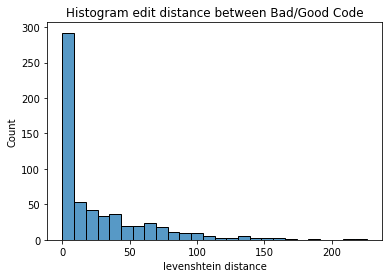

In [44]:
import seaborn as sns
ax = sns.histplot(data=metrics_df['bad_good_d'])
ax.set_title('Histogram edit distance between Bad/Good Code')
ax.set_xlabel('levenshtein distance')

(-338.70000000000005, 2000.0)

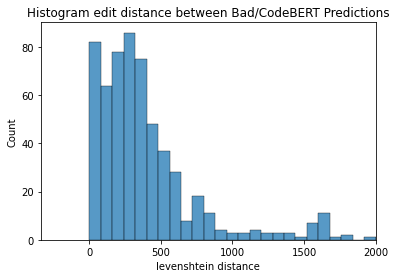

In [45]:

ax = sns.histplot(data=metrics_df['good_codebert_d'])
ax.set_title('Histogram edit distance between Bad/CodeBERT Predictions') # sobre ajuste
ax.set_xlabel('levenshtein distance')
ax.set_xlim(xmax = 2000)

(-313.90000000000003, 2000.0)

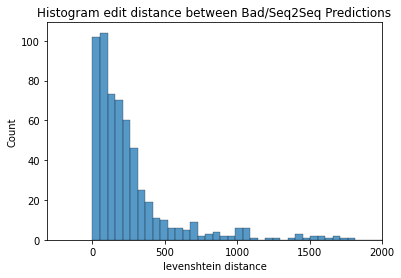

In [46]:

ax = sns.histplot(data=metrics_df['good_seq2seq_d'])
ax.set_title('Histogram edit distance between Bad/Seq2Seq Predictions') # sobre ajuste
ax.set_xlabel('levenshtein distance')
ax.set_xlim(xmax = 2000)

In [47]:
# compute editdistance & difference
from difflib import SequenceMatcher, Differ
import editdistance

# select a random sample
samples = np.random.choice(test_df_e2.shape[0], 4)
samples

def readable_whitespace(line):
    return line.replace("\n", "\\n")

# Two strings are expected as input
def print_diff(text1, text2):
    d = Differ()
    text1 = text1.splitlines(True)
    text2 = text2.splitlines(True)

    text1 = [readable_whitespace(line) for line in text1]
    text1 = [readable_whitespace(line) for line in text2]

    result = list(d.compare(text1, text2))
    sys.stdout.writelines(result)
    sys.stdout.write("\n")

for s in samples:
    
    print('\n')
    print('Original Dataset: ')
    print_diff(test_df_e2['bad'][s], test_df_e2['good'][s])
    print('\n')
    # print('Seq2Seq Prediction: ')
    # print(test_df_e2['bad'][s], test_df_e2['seq2seq'][s])
    # print('\n')
    print('CodeBERT Prediction: ')
    print_diff(test_df_e2['bad'][s], test_df_e2['codebert_predictions'][s])



Original Dataset: 
  lista_u    =    [int(elemento)    for    elemento    in    input().split()]lista_v    =    [int(element)    for    element    in    input().split()]vector_u    =    (lista_u)vector_v    =    (lista_v)matriz    =    [(vector_u),(vector_v)]producto_punto    =    [(i*j)    for    i,    j    in    zip((vector_u),(vector_v))]x=0i=0n=len(producto_punto)valor1=0for    x    in    range(n):                suma    =    valor1+producto_punto[i+x]                x+1                valor1=sumaproducto_punto=sumaprint(producto_punto)  


CodeBERT Prediction: 
  x0=float(input())v0=float(input())v0=float(input())


Original Dataset: 
  Cadena=    input('')Cidini=Cadena.lower()Cidini=Cidini.replace('a','i')Cidini=Cidini.replace('e','i')Cidini=Cidini.replace('o','i')Cidini=Cidini.replace('á','í')Cidini=Cidini.replace('é','í')Resultado=Cidini.replace('ó','í')print(Resultado)  


CodeBERT Prediction: 
  cadena


Original Dataset: 
  x    =    float(input())y    =    float(input())w

In [ ]:
from codebert.bleu import _bleu

ref_file = os.path.join("/content/data/success_wp_test.csv")
seq2seq_trad = os.path.join(output_dir, "seq2seq_without_preprocessing/pred-test_beam5.txt")
codebert_trad = os.path.join(output_dir, "codebert_without_preprocessing/test_1.output")

_bleu(ref_file, codebert_trad)

0.0

In [ ]:
_bleu(ref_file, seq2seq_trad)

62.61

#### ***Experiment 2***

We are going to load the predictions obtained for the test dataset generated by the Seq2Seq baseline model. The BLEU Score is calculated and we repeat the same procedure for the predictions generated by the CodeBERT-based model.
We perform a comparison of the models using the metrics and randomly choose some samples to verify the behavior of both models.

In [46]:
output_dir  = './drive/MyDrive/saved_models/'

test_good = []
with open(os.path.join("/content/data/success_test.csv"), 'r') as f:
    test_good = f.readlines()

test_bad = []
with open(os.path.join("/content/data/failed_test.csv"), 'r') as f:
    test_bad = f.readlines()

codebert_predictions_good = []
with open(os.path.join(output_dir, "codebert_with_preprocessing/test_1.output"), 'r') as f:
    codebert_predictions_good = f.readlines()

seq2seq_predictions = []
with open(os.path.join(output_dir, "seq2seq_with_preprocessing/pred-test_beam5.txt"), 'r') as f:
    seq2seq_predictions = f.readlines()



In [47]:
test_df_e2 = pd.DataFrame({
    'good': test_good,
    'bad': test_bad,
    'codebert_predictions': codebert_predictions_good,
    'seq2seq': seq2seq_predictions, 
    })

# clean last char '\n'

test_df_e2['bad'] = test_df_e2['bad'].str.replace('\\n', '')
test_df_e2['good'] = test_df_e2['good'].str.replace('\\n', '')
test_df_e2['codebert_predictions'] = test_df_e2['codebert_predictions'].str.replace('\n', '')
test_df_e2['seq2seq'] = test_df_e2['seq2seq'].str.replace('\n', '')


test_df_e2['bad']  = [re.sub(r'^([^\s]*)\s+', r'\1', i.replace("\\n", '')) for i in test_df_e2['bad']]
test_df_e2['good'] = [re.sub(r'^([^\s]*)\s+', r'\1', i.replace("\\n", '')) for i in test_df_e2['good']]
test_df_e2['codebert_predictions'] = [re.sub(r'^([^\s]*)\s+', r'\1', i.replace("\\n", '')) for i in test_df_e2['codebert_predictions']]
test_df_e2['seq2seq'] = [re.sub(r'^([^\s]*)\s+', r'\1', i.replace("\\n", '')) for i in test_df_e2['seq2seq']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


In [48]:
test_df_e2.tail()

,good,bad,codebert_predictions,seq2seq
574,n_str= input ( ) <NEWLINE> n = int ( ...,n_str= input ( ) <NEWLINE> n = int ( ...,numero_n= input ( ) <NEWLINE> <NL> <NL> ...,n_str= input ( ) <NEWLINE> n = int ( n_str ) <...
575,x0= float ( input ( ) ) <NEWLINE> v0 ...,x0= float ( input ( ) ) <NEWLINE> v0 ...,x0= float ( input ( ) ) <NEWLINE> v0 ...,x0= float ( input ( ) ) <NEWLINE> v0 = float (...
576,n= input ( <STRING> ) <NEWLINE> n = in...,n= input ( <STRING> ) <NEWLINE> n = in...,numero_n= input ( ) <NEWLINE> <NL> <NL> ...,n= input ( <STRING> ) <NEWLINE> n = int ( n ) ...
577,tamaño= float ( input ( ) ) <NEWLINE> ...,tamaño= float ( input ( ) ) <NEWLINE> ...,x0= float ( input ( ) ) <NEWLINE> v0 ...,tamaño= float ( input ( ) ) <NEWLINE> t = 0 <N...
578,estado= True <NEWLINE> canciones = { } ...,estado= True <NEWLINE> canciones = { } ...,print( <STRING> ) <NEWLINE> if in range ...,estado= True <NEWLINE> canciones = input ( ) <...


In [49]:
# compute editdistance & difference
from difflib import SequenceMatcher, Differ
import editdistance


In [50]:
bad_good_d = []
good_seq2seq_d = []
good_codebert_d = []

bad_good_sm = []
good_seq2seq_sm = []
good_codebert_sm = []

i = 0
for e in test_df_e2.values:
    if i == 0:
      print(e[0], e[1])
    i=i+1

    good, bad, codebert, seq2seq  = e[0], e[1], e[2], e[3]

    bad_good_d.append(editdistance.eval(bad, good))
    good_seq2seq_d.append(editdistance.eval(bad, seq2seq))
    good_codebert_d.append(editdistance.eval(bad, codebert))

    bad_good_sm.append(SequenceMatcher(a=bad, b=good).ratio())
    good_seq2seq_sm.append(SequenceMatcher(a=bad, b=seq2seq).ratio())
    good_codebert_sm.append(SequenceMatcher(a=bad, b=codebert).ratio())

good_toks_joined bad_toks_joined


In [51]:
metrics_df = pd.DataFrame({
    'bad_good_d': bad_good_d, 
    'good_seq2seq_d': good_seq2seq_d, 
    'good_codebert_d': good_codebert_d, 
    'bad_good_sm': bad_good_sm,
    'good_seq2seq_sm': good_seq2seq_sm,
    'good_codebert_sm': good_codebert_sm
    })

Text(0.5, 0, 'levenshtein distance')

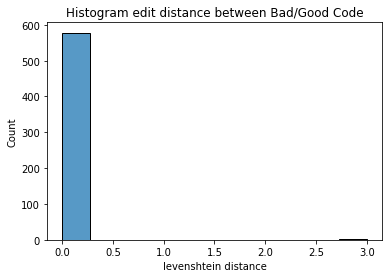

In [52]:
import seaborn as sns
ax = sns.histplot(data=metrics_df['bad_good_d'])
ax.set_title('Histogram edit distance between Bad/Good Code')
ax.set_xlabel('levenshtein distance')

(-140.1, 2000.0)

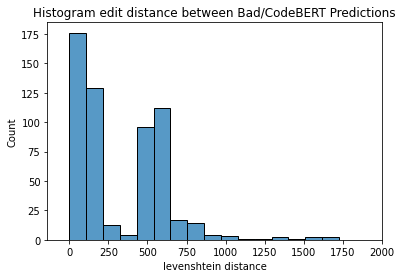

In [53]:

ax = sns.histplot(data=metrics_df['good_codebert_d'])
ax.set_title('Histogram edit distance between Bad/CodeBERT Predictions') # sobre ajuste
ax.set_xlabel('levenshtein distance')
ax.set_xlim(xmax = 2000)

(-154.35000000000002, 2000.0)

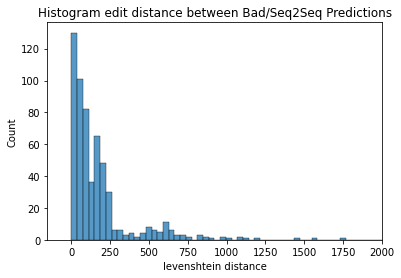

In [54]:
ax = sns.histplot(data=metrics_df['good_seq2seq_d'])
ax.set_title('Histogram edit distance between Bad/Seq2Seq Predictions') # sobre ajuste
ax.set_xlabel('levenshtein distance')
ax.set_xlim(xmax = 2000)

In [ ]:
# compute editdistance & difference
from difflib import SequenceMatcher, Differ
import editdistance

# select a random sample
samples = np.random.choice(test_df_e2.shape[0], 4)
samples

def readable_whitespace(line):
    return line.replace("\n", "\\n")

# Two strings are expected as input
def print_diff(text1, text2):
    d = Differ()
    text1 = text1.splitlines(True)
    text2 = text2.splitlines(True)

    text1 = [readable_whitespace(line) for line in text1]
    text1 = [readable_whitespace(line) for line in text2]

    result = list(d.compare(text1, text2))
    sys.stdout.writelines(result)
    sys.stdout.write("\n")

for s in samples:
    
    print('\n')
    print('Original Dataset: ')
    print_diff(test_df_e2['bad'][s], test_df_e2['good'][s])
    print('Seq2Seq Prediction: ')
    print(test_df_e2['bad'][s], test_df_e2['seq2seq'][s])
    print('CodeBERT Prediction: ')
    print_diff(test_df_e2['bad'][s], test_df_e2['codebert_predictions'][s])



Original Dataset: 
  prin(  <STRING>  )  <NEWLINE>
Seq2Seq Prediction: 
prin(  <STRING>  )  <NEWLINE> prin( <STRING> ) <NEWLINE>
CodeBERT Prediction: 
  print(  <STRING>  <NEWLINE>


Original Dataset: 
  numero_n=  input  (  )  <NEWLINE>  <NL>  <NL>  <NL>
Seq2Seq Prediction: 
numero_n=  input  (  )  <NEWLINE>  <NL>  <NL>  <NL> numero_n= input ( ) <NEWLINE> <NL> <NL> <NL>
CodeBERT Prediction: 
  numero_n=  input  (  )  <NEWLINE>  <NL>  <NL>  <NL>  <NL>  <NL>  <NL>  <NL>  <NL>


Original Dataset: 
  NUM=  (  int  (  float  (  input  (  <STRING>  )  )  )  )  <NEWLINE>  NUM  =  int  (  NUM  )  +  1  <NEWLINE>  SUCESOR  =  NUM  <NEWLINE>  print  (  SUCESOR  )  <NEWLINE>
Seq2Seq Prediction: 
NUM=  (  int  (  float  (  input  (  <STRING>  )  )  )  )  <NEWLINE>  NUM  =  int  (  NUM  )  +  1  <NEWLINE>  SUCESOR  =  NUM  <NEWLINE>  print  (  SUCESOR  )  <NEWLINE> NUM= ( int ( float ( input ( <STRING> ) ) ) ) <NEWLINE> NUM = int ( NUM ) + 1 <NEWLINE> SUCESOR = NUM <NEWLINE> print ( SUCESOR ) <N

In [ ]:
from codebert.bleu import _bleu

ref_file = os.path.join("/content/data/success_test.csv")
seq2seq_trad = os.path.join(output_dir, "seq2seq_with_preprocessing/pred-test_beam5.txt")
codebert_trad = os.path.join(output_dir, "codebert_with_preprocessing/test_1.output")

_bleu(ref_file, codebert_trad)

24.58

In [ ]:
_bleu(ref_file, seq2seq_trad)

75.02